source: Quantinsti, Python for Machine Learning in Finance. https://quantra.quantinsti.com/startCourseDetails?cid=189&section_no=11&unit_no=9&course_type=free&unit_type=Notebook


Stany Vanhemelrijck, 17 July

Creating functions.

# Import Libraries

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# Read positions data

In [3]:
def read_data(file):
    
    strategy_data = pd.read_csv("./results/results.csv", index_col=0)

    # Read the close price
    strategy_data['close'] = pd.read_csv(
        file, index_col=0).loc[strategy_data.index[0]:]['close']
    # changing the type of the index to datetime
    strategy_data.index = pd.to_datetime(strategy_data.index)
    
    return strategy_data

In [4]:
data = read_data("ETHBTC-1m-data.csv")

# Calculate Strategy Returns

In [5]:
def calculalate_strategy_returns(strategy_data):
    
    # This is only necessary to show the difference of adding transaction costs.
    pd.options.display.float_format = "{:,.10f}".format

    # Calculate the percentage change
    strategy_data['pct_change'] = strategy_data['close'].pct_change()

    # Calculate the strategy returns
    # Using Binance transaction fee 0.1%
    # Rounding up to 10 digits.
    # if the predicition is 1 (up) we multiply that by the return of that minute.
    # when the predition is correct we multiply 1 by 1 % for example, and 
    # add that as a strategy return. 
    # is the prediction incorrect we multiple 1 by -1% for example, and
    # we add a negative return. 
    strategy_data['strategy_returns'] = ((strategy_data['signal'].shift(1) * \
        strategy_data['pct_change']) *0.999)

    # Drop the missing values
    strategy_data.dropna(inplace=True)
    
    return strategy_data


In [6]:
data = calculalate_strategy_returns(data)

Calculate the percentage change: 
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pct_change.html
the result in the column * 100 = the percentage, so its not written in percentage. 

In [7]:
data.head()

,signal,close,pct_change,strategy_returns
open time,,,,
2022-01-28 14:35:00,1.0000000000,0.0650800000,-0.0022995554,-0.0022972559
2022-01-28 14:36:00,1.0000000000,0.0651860000,0.0016287646,0.0016271358
2022-01-28 14:37:00,-1.0000000000,0.0651690000,-0.0002607922,-0.0002605314
2022-01-28 14:38:00,1.0000000000,0.0651000000,-0.0010587856,0.0010577268
2022-01-28 14:39:00,1.0000000000,0.0651200000,0.0003072197,0.0003069124


# Plot the Equity Curve

In [11]:
def equity_curve(strategy_data):
    '''This function takes the strategy data as an input 
    and outputs the eqiuty curve and the cummulative return. '''
    # Calculate the cumulative returns
    strategy_data['cumulative_returns'] = (1+strategy_data['strategy_returns']).cumprod()


    # Plot cumulative strategy returns (equity curve)
    strategy_data['cumulative_returns'].plot(figsize=(15, 7), color='green')
    plt.title('Equity Curve', fontsize=18)
    plt.ylabel('Cumulative returns')
    plt.tight_layout()
    plt.show()

    cumulative_returns = (strategy_data['cumulative_returns'][-1] - 1)*100
    print("The cumulative return is {0:.2f}%.".format(cumulative_returns))

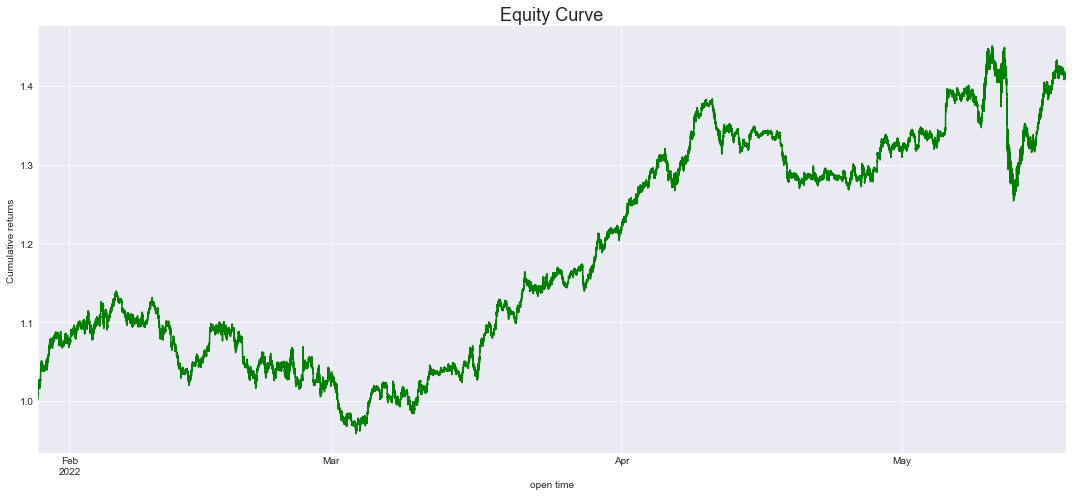

The cumulative return is 41.13%.


In [12]:
equity_curve(data)

# Performance Metrics

In [18]:
def annualised_return(strategy_data):
    # Calculate the annualised returns
    # Cryptocurrencies are tradeable 24/7.
    annualised_return = ((strategy_data['cumulative_returns'][-1]) **
                    (365*24*60/strategy_data.shape[0]) - 1) * 100
    
    print("The annualised return is {0:.2f}%.".format(annualised_return))
    return annualised_return

In [20]:
a_return = annualised_return(data)

The annualised return is 214.12%.


In [21]:
def annualised_volatility(strategy_data):
    # Calculate the annualised volatility
    annualised_volatility = strategy_data['strategy_returns'].std()*np.sqrt(
        365*24*60) * 100
    print("The annualised volatility is {0:.2f}%.".format(annualised_volatility))
    return annualised_volatility

In [22]:
a_volatility = annualised_volatility(data)

The annualised volatility is 37.95%.


In [25]:
def drawdown(strategy_data):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(
        strategy_data['cumulative_returns'].dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = ((strategy_data['cumulative_returns'])/running_max - 1) * 100

    # Calculate the maximum drawdown
    max_dd = drawdown.min()
    print("The maximum drawdown is {0:.2f}%.".format(max_dd))

    
    # Plotting the drawdown.
    fig = plt.figure(figsize=(15, 7))

    # Plot max drawdown
    plt.plot(drawdown, color='red')
    # Fill in-between the drawdown
    plt.fill_between(drawdown.index, drawdown.values, color='red')
    plt.title('Strategy Drawdown', fontsize=14)
    plt.ylabel('Drawdown(%)', fontsize=12)
    plt.xlabel('Year', fontsize=12)

    plt.tight_layout()
    plt.show()
    
    return max_dd 

The maximum drawdown is -15.87%.


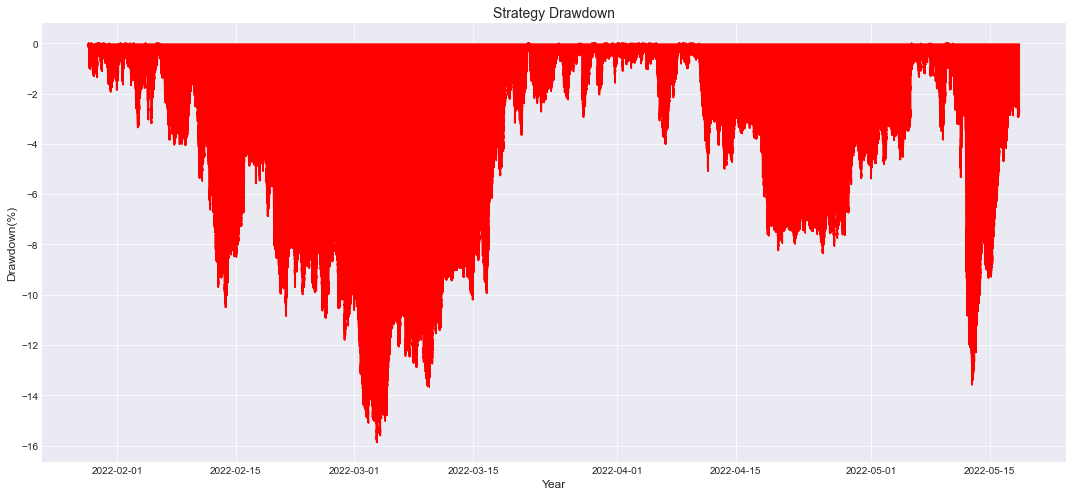

In [27]:
dd = drawdown(data)

In [28]:
def sharpe_ratio(strategy_data):

    # Calculate the Sharpe ratio
    sharpe_ratio = round(strategy_data['strategy_returns'].mean() /
                         strategy_data['strategy_returns'].std() * np.sqrt(365*24*60), 2)
    print("The Sharpe ratio is {0:.2f}.".format(sharpe_ratio))
    
    return sharpe_ratio

In [30]:
sr = sharpe_ratio(data)

The Sharpe ratio is 3.21.
